In [5]:
import pandas as pd
import torch
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()

In [6]:
from src.datasets.EuroSatMSFeatures import EuroSatMSFeatures

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv(config.TRAIN_FILE)

dataset = EuroSatMSFeatures(df, config.TRAIN_MS_DIR)



Preloading images...
Number of images: 27000
Number of jobs:   -4 


In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import numpy as np
import xgboost as xgb

feats = np.array([x[0] for x in dataset.samples])
labels = np.array([x[1] for x in dataset.samples])

skf_idx = []
skf = StratifiedKFold(n_splits=5)
for fold, (train_index, test_index) in enumerate(skf.split(feats, labels)):
    skf_idx.append((train_index, test_index))
    
model = XGBClassifier(
    nthread=-1,
    seed=27,
    tree_method="hist", 
    device="cuda"
)

parameter_space = {
    'n_estimators': [1000],
    'learning_rate': [0.0001, 0.1],
    'max_depth': [3, 8],
    'subsample': [0.3, 0.7],
    'colsample_bytree': [0.3, 0.7],
    'booster': ['gbtree'],
    'reg_lambda': [1, 15],
    'reg_alpha': [0, 10],
    'gamma': [0.1, 1]
}

fit_param = {
    'early_stopping_rounds': 10,
}

In [4]:
clf = BayesSearchCV(estimator=model,
                    search_spaces=parameter_space,
                    fit_params=fit_param,
                    cv=skf_idx[:1],
                    n_iter=30,
                    scoring='accuracy',
                    verbose=4)

clf.fit(feats, y=labels)
print(clf.cv_results_)
print(clf.best_score_)
print(clf.best_params_)
results = pd.DataFrame(clf.cv_results_)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [17:54:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV 1/1] END booster=gbtree, colsample_bytree=0.31911999132014324, gamma=0.5054420471607272, learning_rate=0.05351321560930494, max_depth=5, n_estimators=1000, reg_alpha=7, reg_lambda=7, subsample=0.37433346353303987;, score=0.723 total time=  34.0s
Fitting 1 folds for each of 1 candidates, totalling 1 fits


KeyboardInterrupt: 

In [8]:
from matplotlib import pyplot as plt
from src.datasets.EuroSatTestFeatures import EuroSatTestSetFeatures

train_index, test_index = skf_idx[0]
train_data = [feats[i] for i in train_index]
train_labels = [labels[i] for i in train_index]
test_data = [feats[i] for i in test_index]
test_labels = [labels[i] for i in test_index]

param = {
    'n_estimators': 1000,
    'learning_rate': 0.06,
    'max_depth': 5,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'booster': 'gbtree',
    'reg_lambda': 1,
    'reg_alpha': 4,
    'gamma': 0.3
}

model = XGBClassifier(
    *param,
    objective='multi:softmax',
    nthread=-1,
    seed=27,
    tree_method="hist", 
    device="cuda",
    early_stopping_rounds=100
)

model.fit(train_data, 
          y=train_labels, 
          eval_set=[(test_data, test_labels)])

preds = model.predict(test_data)
# compute accuracy
acc = np.mean(preds == test_labels)

print("Number of samples in test set: ", len(test_labels))
print("Number of samples in train set: ", len(train_labels))
print(f'Accuracy: {acc}')


/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/xgboost/core.py:727: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	validation_0-mlogloss:1.85850
[1]	validation_0-mlogloss:1.64821
[2]	validation_0-mlogloss:1.50648
[3]	validation_0-mlogloss:1.40357
[4]	validation_0-mlogloss:1.32614
[5]	validation_0-mlogloss:1.26275
[6]	validation_0-mlogloss:1.21289
[7]	validation_0-mlogloss:1.17247
[8]	validation_0-mlogloss:1.13901
[9]	validation_0-mlogloss:1.10950
[10]	validation_0-mlogloss:1.08597
[11]	validation_0-mlogloss:1.06476
[12]	validation_0-mlogloss:1.04457
[13]	validation_0-mlogloss:1.02838
[14]	validation_0-mlogloss:1.01319
[15]	validation_0-mlogloss:0.99967
[16]	validation_0-mlogloss:0.98881
[17]	validation_0-mlogloss:0.97960
[18]	validation_0-mlogloss:0.96964
[19]	validation_0-mlogloss:0.96047
[20]	validation_0-mlogloss:0.95219
[21]	validation_0-mlogloss:0.94421
[22]	validation_0-mlogloss:0.93777
[23]	validation_0-mlogloss:0.93192
[24]	validation_0-mlogloss:0.92551
[25]	validation_0-mlogloss:0.92217
[26]	validation_0-mlogloss:0.91730
[27]	validation_0-mlogloss:0.91234
[28]	validation_0-mlogloss:0.9


Preloading images...
Number of images: 4232
Number of jobs:   -4 
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([255, 523, 546, 812, 244, 270, 260, 429, 622, 271]))
Predicted: Forest, sample: 2924
(64, 64, 3)


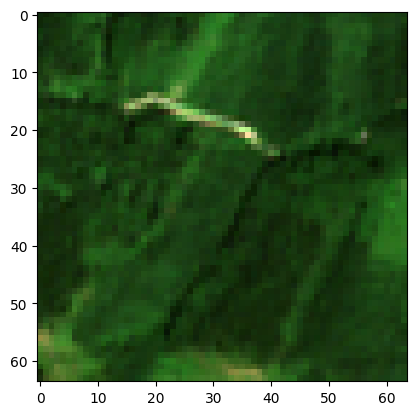

Predicted: HerbaceousVegetation, sample: 4181
(64, 64, 3)


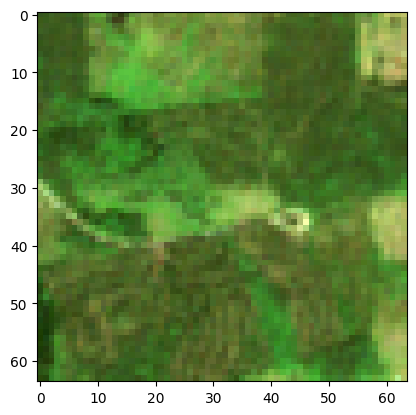

Predicted: Forest, sample: 554
(64, 64, 3)


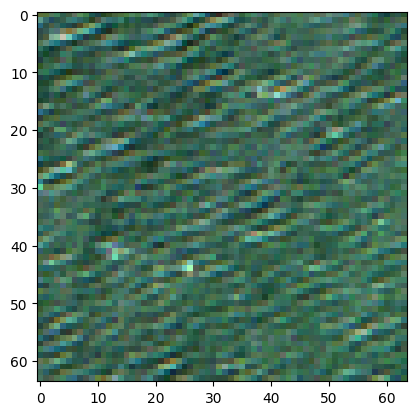

Predicted: PermanentCrop, sample: 943
(64, 64, 3)


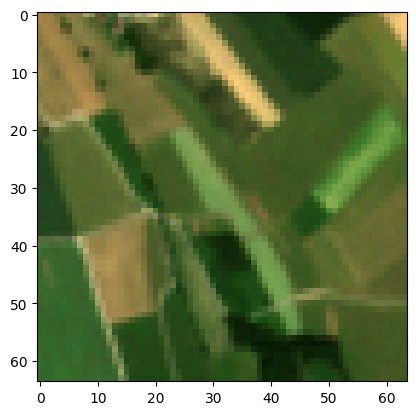

Predicted: Pasture, sample: 3767
(64, 64, 3)


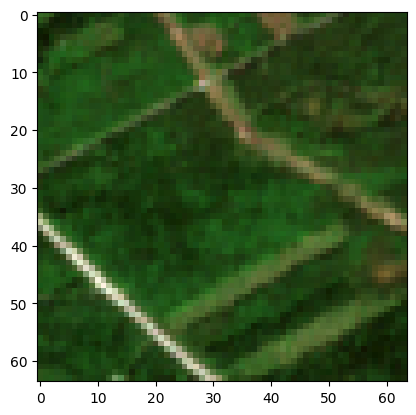

Predicted: Forest, sample: 1153
(64, 64, 3)


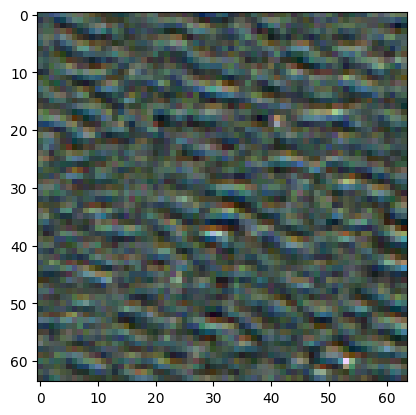

Predicted: Pasture, sample: 2737
(64, 64, 3)


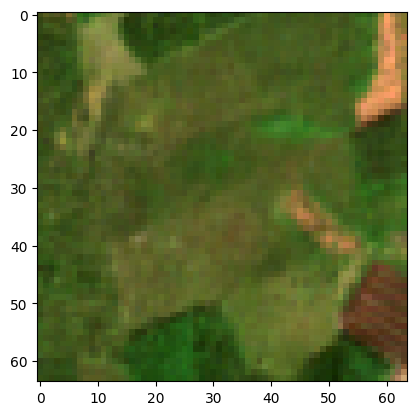

Predicted: AnnualCrop, sample: 4053
(64, 64, 3)


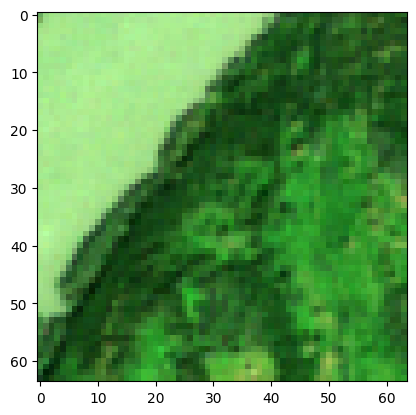

Predicted: Industrial, sample: 2710
(64, 64, 3)


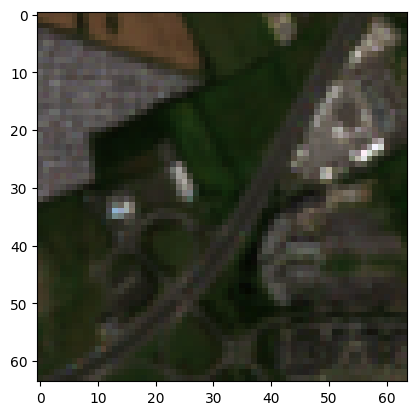

Predicted: PermanentCrop, sample: 2
(64, 64, 3)


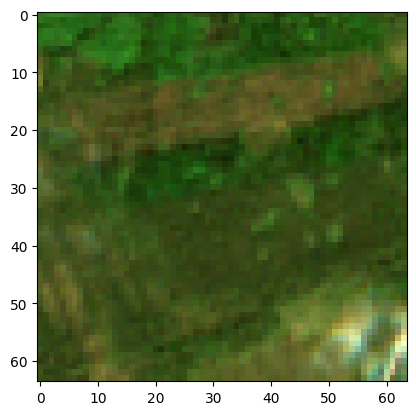

Predicted: Industrial, sample: 3736
(64, 64, 3)


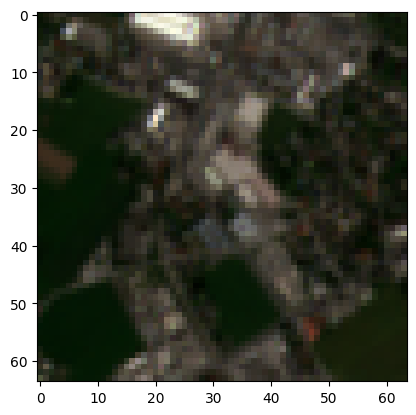

Predicted: AnnualCrop, sample: 3766
(64, 64, 3)


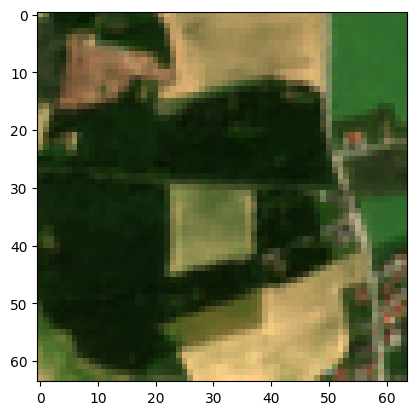

Predicted: Residential, sample: 62
(64, 64, 3)


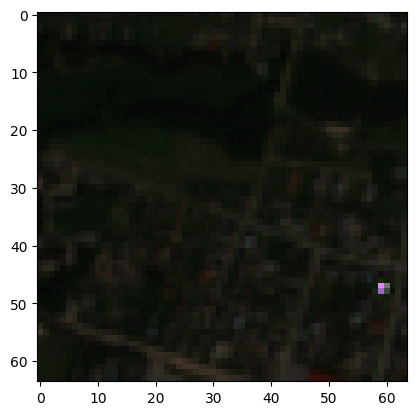

Predicted: Forest, sample: 2159
(64, 64, 3)


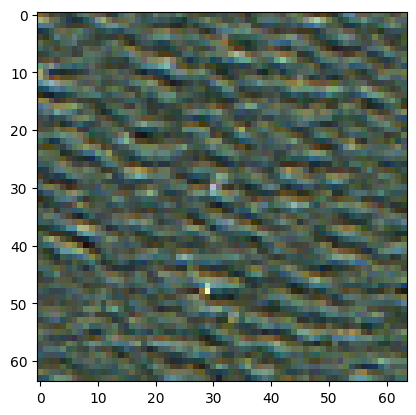

Predicted: Highway, sample: 2235
(64, 64, 3)


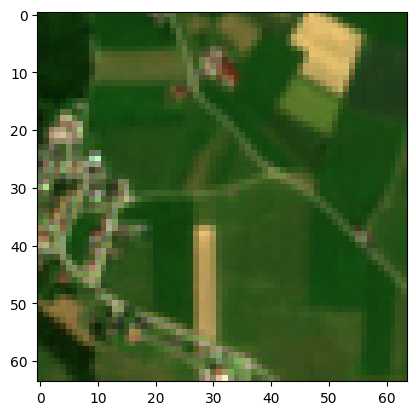

Predicted: Pasture, sample: 2640
(64, 64, 3)


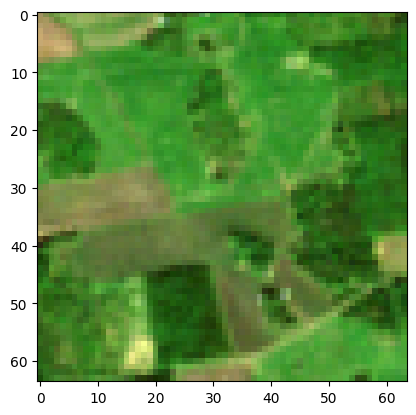

Predicted: Highway, sample: 3104
(64, 64, 3)


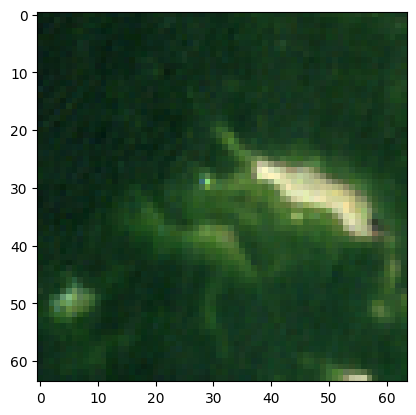

Predicted: Highway, sample: 900
(64, 64, 3)


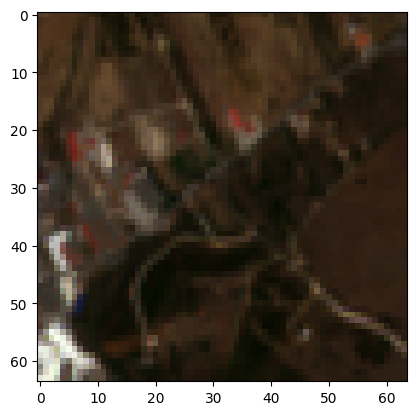

Predicted: Highway, sample: 321
(64, 64, 3)


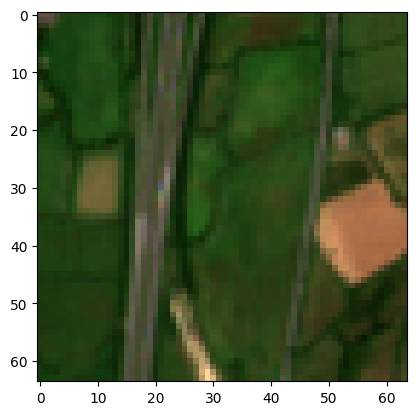

Predicted: SeaLake, sample: 2284
(64, 64, 3)


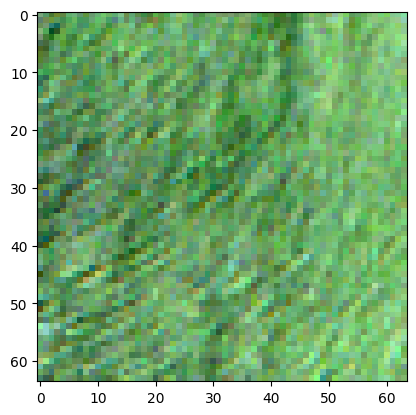

In [9]:
test_set = EuroSatTestSetFeatures(config.TEST_MS_DIR)

test_feats = np.array([x[0] for x in test_set.samples])
test_ids = np.array([x[1] for x in test_set.samples])

preds = model.predict(test_feats)

print(np.unique(preds, return_counts=True))
pred_labels = test_set.enc.inverse_transform(preds.astype(int))

for i in range(20, 40):
    print(f'Predicted: {pred_labels[i]}, sample: {test_ids[i]}')
    raw = np.load(f"data/test/NoLabel/test_{test_ids[i]}.npy")
    img = raw[:, :, [3, 2, 1]]
    print(img.shape)
    rgb_min = img.min()
    rgb_max = img.max()
    img = (img - rgb_min) / (rgb_max - rgb_min)
    
    #img = img.permute(1, 2, 0)
    plt.imshow(img)
    plt.show()

In [10]:
sub_df = pd.DataFrame({'test_id': test_ids, 'label': pred_labels})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())

sub_df.to_csv('submission.csv', index=False)

      test_id          label
1218        0        Pasture
1454        1        Highway
29          2  PermanentCrop
2598        3        SeaLake
2512        4  PermanentCrop
